In [1]:
# This notebook was built in Catherine's vectorenv
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import glob
import datetime
import pylab
import matplotlib as plt
import datetime as datetime  
import statsmodels.api as sm  
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('ggplot')

/Users/ckuhn/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
%cd /Users/ckuhn/Documents/ABOVE/Landsat8_data/
NDCI_raw = pd.read_csv('NDCI.csv', low_memory=False)
rgb_raw = pd.read_csv('rgb.csv', low_memory=False)
blueGreen_raw = pd.read_csv('blueGreen.csv', low_memory=False)
nirSWIR_raw = pd.read_csv('nirSWIR.csv', low_memory=False)

/Users/ckuhn/Documents/ABOVE/Landsat8_data


In [4]:
NDCI_raw.head(2)

,system:time_start,Lake_1-46-3,Abraham Lake,Greenpepper Lake,Sands of Time,Boot Lake,Canvasback Lake,YF04,Scoter Lake,YF03,...,West Crazy Lake,YF20,YF08,YF14,Thumb Lake,Buddy Lake,Twelvemile Lake,Twin Lake,Shack Lake,YF02
0,"Jun 1, 2016",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Jun 1, 2016",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Monthly Averages Per Algorithms

In [9]:
# Melt them all 
df1 = pd.melt(NDCI_raw, id_vars=['system:time_start'], var_name='Lake', value_name = 'Reflectance')
#df1['Reflectance'] = df1['Reflectance'].add(0.74)
df2 = pd.melt(rgb_raw, id_vars=['system:time_start'], var_name='Lake', value_name = 'Reflectance')
df3 = pd.melt(nirSWIR_raw, id_vars=['system:time_start'], var_name='Lake', value_name = 'Reflectance')
df4 = pd.melt(blueGreen_raw, id_vars=['system:time_start'], var_name='Lake', value_name = 'Reflectance')

df4.head(1)

,system:time_start,Lake,Reflectance
0,"Jun 1, 2016",Lake_1-46-3,NaN


In [10]:
# Add column with categorical
df1['Algorithm'] = 'NDCI'
df2['Algorithm'] = 'RGB'
df3['Algorithm'] = 'nirSWIR'
df4['Algorithm'] = 'blueGreen'

In [11]:
df3.head(1)

,system:time_start,Lake,Reflectance,Algorithm
0,"Jun 1, 2016",Lake_1-46-3,NaN,nirSWIR


In [12]:
df1['Reflectance'].min()

-0.73999999999999999

In [13]:
# Concatenate
boss = df1.append(df2).append(df3).append(df4)

In [14]:
print(boss.shape)
boss.head(1)

(5088, 4)


,system:time_start,Lake,Reflectance,Algorithm
0,"Jun 1, 2016",Lake_1-46-3,NaN,NDCI


In [15]:
# Now resample to the month
boss0 = boss.set_index(pd.DatetimeIndex(boss['system:time_start']))
boss1 = boss0.resample("M").median()

boss2 = boss1.reset_index()
boss.head(1)

,system:time_start,Lake,Reflectance,Algorithm
0,"Jun 1, 2016",Lake_1-46-3,NaN,NDCI


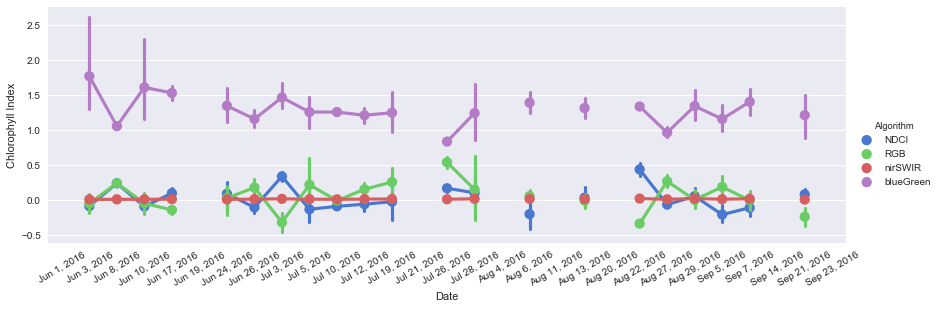

In [16]:
# Draw a nested barplot to show survival for class and sex

g = sns.factorplot(x="system:time_start", y="Reflectance", hue="Algorithm", data=boss,
                   palette="muted", size=4, aspect=3)

g.despine(left=True)
g.set_ylabels("Chlorophyll Index")
g.set_xlabels("Date")
g.set_xticklabels(rotation=30)

#plt.tight_layout()

In [26]:
print('Counts')
#boss.groupby(['system:time_start', 'Algorithm']).mean()#.plot(kind = 'bar')
bossx = boss0.dropna()
grouper = bossx.groupby([pd.TimeGrouper('1M'), 'Algorithm'])
grouper['Algorithm'].count()

Counts


system:time_start  Algorithm
2016-06-30         NDCI         110
                   RGB          110
                   blueGreen    110
                   nirSWIR      110
2016-07-31         NDCI          59
                   RGB           59
                   blueGreen     59
                   nirSWIR       59
2016-08-31         NDCI          54
                   RGB           54
                   blueGreen     54
                   nirSWIR       54
2016-09-30         NDCI          52
                   RGB           52
                   blueGreen     52
                   nirSWIR       52
Name: Algorithm, dtype: int64

In [27]:
print("monthly mean algorithm results from Landsat 8")
result = grouper['Reflectance'].mean().unstack('Algorithm')
result
#https://stackoverflow.com/questions/32012012/pandas-resample-timeseries-with-groupby

monthly mean algorithm results from Landsat 8


Algorithm,NDCI,RGB,blueGreen,nirSWIR
system:time_start,,,,
2016-06-30,-0.027527,-0.036555,1.508773,0.005027
2016-07-31,-0.005085,0.138847,1.225644,0.008102
2016-08-31,-0.008852,0.012667,1.309815,0.010537
2016-09-30,-0.092750,-0.017904,1.274788,0.007135


In [28]:
print("monthly standard deviation algorithm results from Landsat 8")
stderr = grouper['Reflectance'].std().unstack('Algorithm')
stderr

monthly standard deviation algorithm results from Landsat 8


Algorithm,NDCI,RGB,blueGreen,nirSWIR
system:time_start,,,,
2016-06-30,0.234907,0.316119,1.154989,0.002510
2016-07-31,0.317799,0.360855,0.348825,0.008364
2016-08-31,0.338191,0.251464,0.381001,0.014590
2016-09-30,0.285822,0.353445,0.497806,0.020355


In [29]:
print("monthly minimum of algorithm results from Landsat 8")
stderr = grouper['Reflectance'].min().unstack('Algorithm')
stderr

monthly minimum of algorithm results from Landsat 8


Algorithm,NDCI,RGB,blueGreen,nirSWIR
system:time_start,,,,
2016-06-30,-0.505,-1.152,0.000,-0.001
2016-07-31,-0.740,-0.581,0.651,-0.001
2016-08-31,-0.608,-0.483,0.718,0.001
2016-09-30,-0.591,-0.708,0.000,-0.010


/Users/ckuhn/Documents/ABOVE/Figures


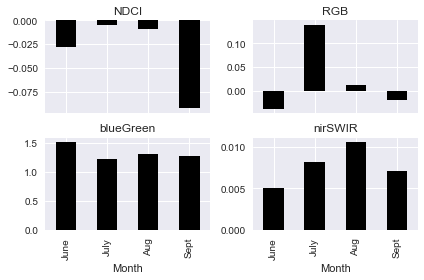

In [30]:
fig, ax = plt.subplots(2, 2)

result['NDCI'].plot(kind= 'bar', color ='black', ax=ax[0,0]) #no need to specify for first axis
ax[0, 0].set_xlabel('')
ax[0, 0].set_title('NDCI')
ax[0, 0].set_xticklabels([])

result['RGB'].plot(kind= 'bar', color ='black', ax=ax[0, 1]) #no need to specify for first axis
ax[0, 1].set_xlabel('')
ax[0, 1].set_title('RGB')
ax[0, 1].set_xticklabels([])


result['blueGreen'].plot(kind= 'bar', color ='black', ax=ax[1, 0]) #no need to specify for first axis
ax[1, 0].set_xlabel('Month')
ax[1, 0].set_title('blueGreen')
labels = ['June','July', 'Aug', 'Sept']
ax[1, 0].set_xticklabels(labels)

result['nirSWIR'].plot(kind= 'bar', color ='black', ax=ax[1, 1]) #no need to specify for first axis
ax[1, 1].set_xlabel('Month')
ax[1, 1].set_title('nirSWIR')
ax[1, 1].set_xticklabels(labels)

plt.tight_layout()

%cd /Users/ckuhn/Documents/ABOVE/figures
plt.savefig('overall_alg_bar.png', dpi = 300)

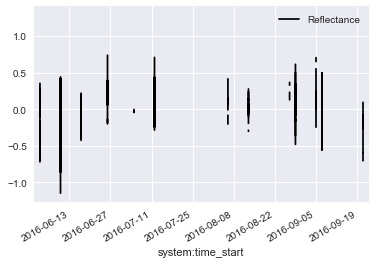

In [31]:
## RGB plots 
df2 = df2.set_index(pd.DatetimeIndex(df2['system:time_start']))
df2.plot(y = 'Reflectance', color ='black') 

/Users/ckuhn/Documents/ABOVE/Figures


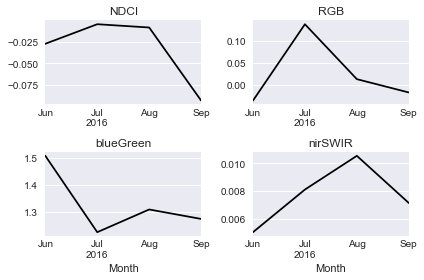

In [48]:
fig, ax = plt.subplots(2, 2)

result['NDCI'].plot(color ='black', ax=ax[0,0]) #no need to specify for first axis
ax[0, 0].set_xlabel('')
ax[0, 0].set_title('NDCI')
ax[0, 0].set_xticklabels([])

result['RGB'].plot(color ='black', ax=ax[0, 1]) #no need to specify for first axis
ax[0, 1].set_xlabel('')
ax[0, 1].set_title('RGB')
ax[0, 1].set_xticklabels([])


result['blueGreen'].plot(color ='black', ax=ax[1, 0]) #no need to specify for first axis
ax[1, 0].set_xlabel('Month')
ax[1, 0].set_title('blueGreen')
labels = ['June','July', 'Aug', 'Sept']
ax[1, 0].set_xticklabels(labels)

result['nirSWIR'].plot(color ='black', ax=ax[1, 1]) #no need to specify for first axis
ax[1, 1].set_xlabel('Month')
ax[1, 1].set_title('nirSWIR')
ax[1, 1].set_xticklabels(labels)

plt.tight_layout()


%cd /Users/ckuhn/Documents/ABOVE/figures
plt.savefig('overall_alg_line_l8.png', dpi = 300)

/Users/ckuhn/Documents/ABOVE/Figures


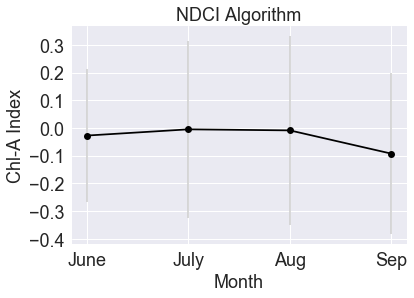

In [36]:
# Scaled NDCI

e = [0.24, 0.32, 0.34, 0.29]
# to absolute min : y = [0.712473, 0.734915, 0.731148,  0.647250]
# to monthly min y = [0.065224, 0.087666, 0.000423,0.000001]

y = [-0.027527, -0.005085, -0.008852,-0.092750]
x = [6, 7, 8, 9]

LABELS = ['June', 'July', 'Aug', 'Sep']

plt.ylabel('Chl-A Index', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.title('NDCI Algorithm', fontsize=18)

plt.errorbar(x, y, yerr=e, fmt='o-', color= 'black', ecolor='lightgray')
plt.xticks(x, LABELS, fontsize=18)
plt.yticks(fontsize=18)


%cd /Users/ckuhn/Documents/ABOVE/figures
plt.savefig('NDCI_L8_err.png', dpi = 300)

plt.show()

/Users/ckuhn/Documents/ABOVE/Figures


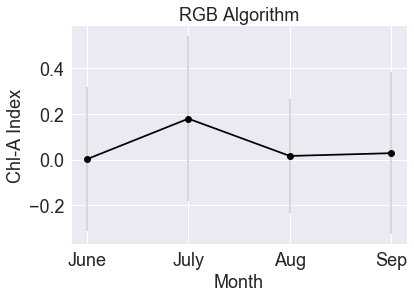

In [37]:
# RGB

e = [0.316119, 0.360855, 0.251464, 0.353445]
y = [0.0016119, 0.178847, 0.015667,  0.027904]
x = [6, 7, 8, 9]
LABELS = ['June', 'July', 'Aug', 'Sep']

plt.ylabel('Chl-A Index', fontsize=18)
plt.xlabel('Month', fontsize=18)
plt.title('RGB Algorithm', fontsize=18)

plt.errorbar(x, y, yerr=e, fmt='o-', color= 'black', ecolor='lightgray')
plt.xticks(x, LABELS, fontsize=18)
plt.yticks(fontsize=18)


%cd /Users/ckuhn/Documents/ABOVE/figures
plt.savefig('RGB_L8_err.png', dpi = 300)

plt.show()

/Users/ckuhn/Documents/ABOVE/Figures


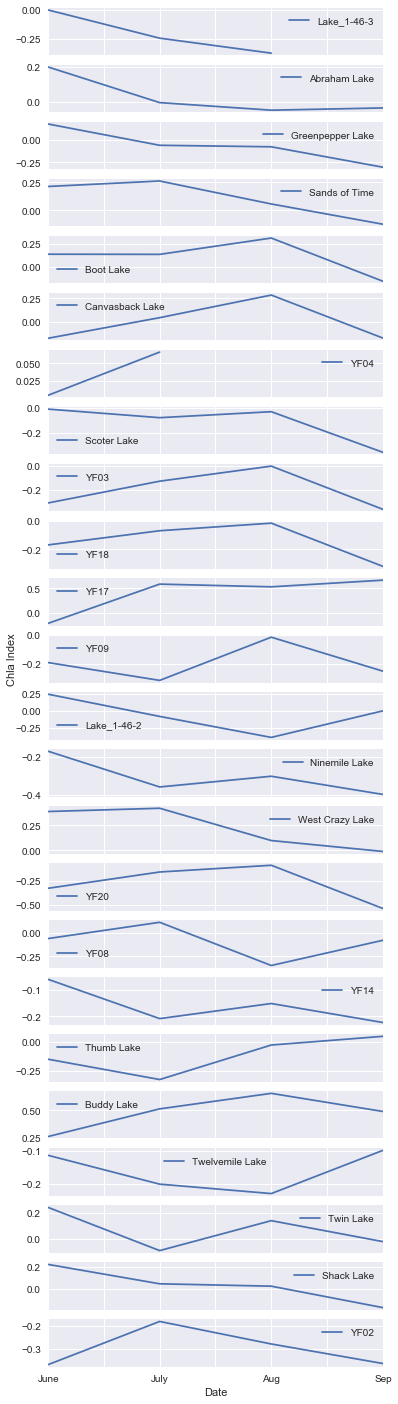

In [47]:
#NDCI_raw = pd.read_csv('NDCI.csv', low_memory=False)
#rgb_raw = pd.read_csv('rgb.csv', low_memory=False)
#blueGreen_raw = pd.read_csv('blueGreen.csv', low_memory=False)
#nirSWIR_raw = pd.read_csv('nirSWIR.csv', low_memory=False)

NDCI_df = NDCI_raw.set_index(pd.DatetimeIndex(NDCI_raw['system:time_start']))
NDCI  = NDCI_df.groupby([(NDCI_df.index.year),(NDCI_df.index.month)]).mean()
data = NDCI


fig, ax = plt.subplots(len(data.columns))
for idx in range(len(data.columns)):
    data[data.columns[idx]].plot(ax=ax[idx])

ax[idx//2].set_ylabel("Chla Index")

# Retrieve an element of a plot and set properties
for idx in range(len(data.columns)):
    ax[idx].set_xticklabels('')
    ax[idx].legend()
    
ax[idx].set_xlabel("Date")
ax[idx].set_xlabel("Date")
ax[idx].set_xlabel("Date")

ax[idx].set_xticklabels(['June','', 'July','', 'Aug','', 'Sep'])

fig.set_size_inches([6, 25])

%cd /Users/ckuhn/Documents/ABOVE/figures
plt.savefig('indv_TS_rgb_L8.png', dpi = 300)

/Users/ckuhn/Documents/ABOVE/Figures


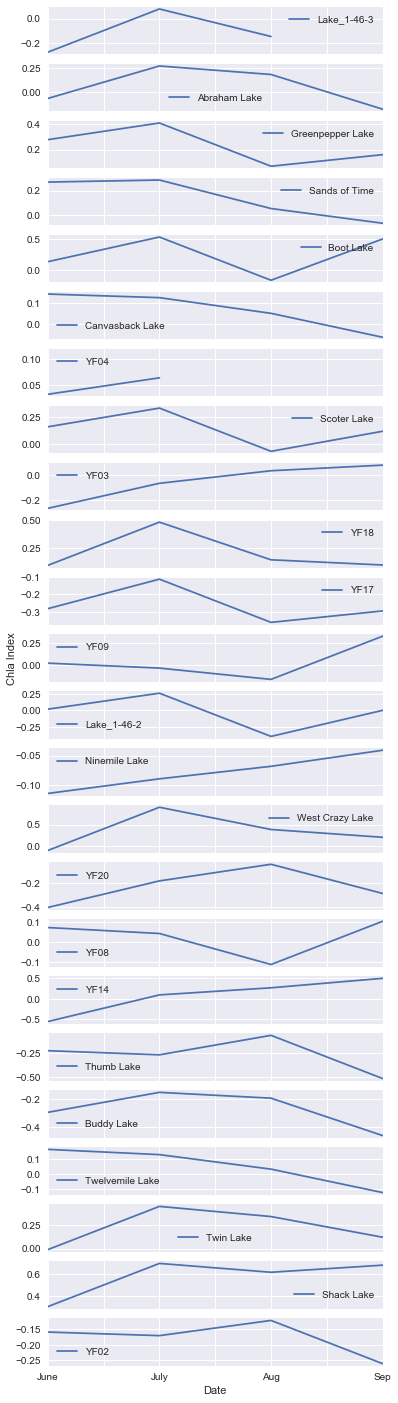

In [44]:
#NDCI_raw = pd.read_csv('NDCI.csv', low_memory=False)
#rgb_raw = pd.read_csv('rgb.csv', low_memory=False)
#blueGreen_raw = pd.read_csv('blueGreen.csv', low_memory=False)
#nirSWIR_raw = pd.read_csv('nirSWIR.csv', low_memory=False)

rgb_df = rgb_raw.set_index(pd.DatetimeIndex(rgb_raw['system:time_start']))
rgb  = rgb_df.groupby([(rgb_df.index.year),(rgb_df.index.month)]).mean()
data = rgb


fig, ax = plt.subplots(len(data.columns))
for idx in range(len(data.columns)):
    data[data.columns[idx]].plot(ax=ax[idx])

ax[idx//2].set_ylabel("Chla Index")

# Retrieve an element of a plot and set properties
for idx in range(len(data.columns)):
    ax[idx].set_xticklabels('')
    ax[idx].legend()
    
ax[idx].set_xlabel("Date")
ax[idx].set_xlabel("Date")
ax[idx].set_xlabel("Date")

ax[idx].set_xticklabels(['June','', 'July','', 'Aug','', 'Sep'])

fig.set_size_inches([6, 25])

%cd /Users/ckuhn/Documents/ABOVE/figures
#plt.savefig('indv_TS_rgb.png', dpi = 300)